<font size=3> &emsp;&emsp;影响房价的因素有很多，在本题的数据集中，有79个解释变量几乎描述了爱荷华州艾姆斯（Ames, Iowa）住宅的方方面面，要求预测每套房屋最终的销售价格。 </font>

## 数据

<img src='./变量.png' width="80%" height="80%">


**评价指标：RMSE，即根据预测值的对数和观察到的房价对数之间的均方根误差对提交结果进行评估。公式如下：**

$$ RMSE = \sqrt{\frac {\sum_{i=1}^N{(y_i-\hat{y}_i)^2}} N}\, $$


## 代码实现

### 导入python包

In [402]:
import warnings
warnings.filterwarnings("ignore")   # 忽略警告信息

from scipy.stats import norm, skew  # 获取统计信息
from scipy import stats
import numpy as np
import pandas as pd    # 数据处理包
import seaborn as sns  # 绘图包
color = sns.color_palette()
sns.set_style('darkgrid')
import matplotlib.pyplot as plt 
%matplotlib inline

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))  # 限制浮点输出到小数点后3位

import os
print('\n'.join(os.listdir('./input')))  # 列出目录中可用的文件

sample_submission.csv
test.csv
train.csv


### 加载数据集

In [403]:
# 加载数据
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

In [404]:
# 检查样本和特征的数量
print("删除Id列前训练集大小: {} ".format(train.shape))
print("删除Id列前测试集大小: {} ".format(test.shape))

删除Id列前训练集大小: (1460, 81) 
删除Id列前测试集大小: (1459, 80) 


In [405]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [406]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [407]:
# 保存Id列
train_ID = train['Id']
test_ID = test['Id']

# 删除原数据集的Id列
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

### 数据预处理和特征工程

#### 异常值处理

Text(0.5, 0, 'GrLivArea')

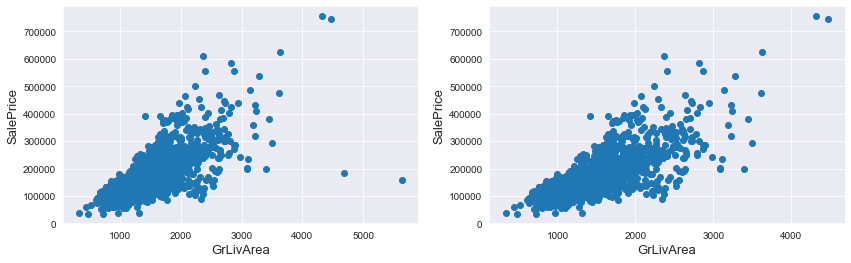

In [408]:
plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)
plt.subplot(122)
plt.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)

#### 目标变量分析

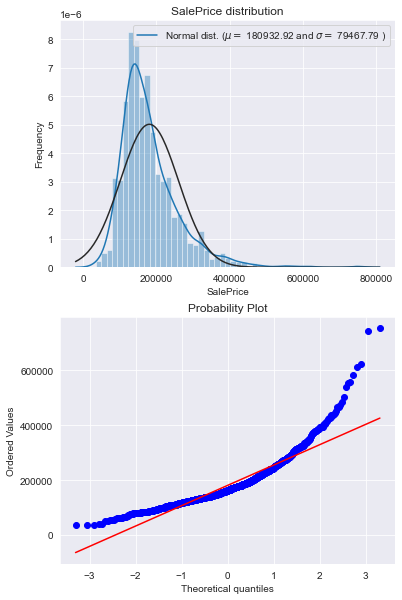

In [409]:
# 分布图
fig, ax = plt.subplots(nrows=2, figsize=(6, 10))
sns.distplot(train['SalePrice'], fit=norm, ax=ax[0])
(mu, sigma) = norm.fit(train['SalePrice'])
ax[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
ax[0].set_ylabel('Frequency')
ax[0].set_title('SalePrice distribution')
# QQ图
stats.probplot(train['SalePrice'], plot=ax[1])
plt.show()

正态分布处理

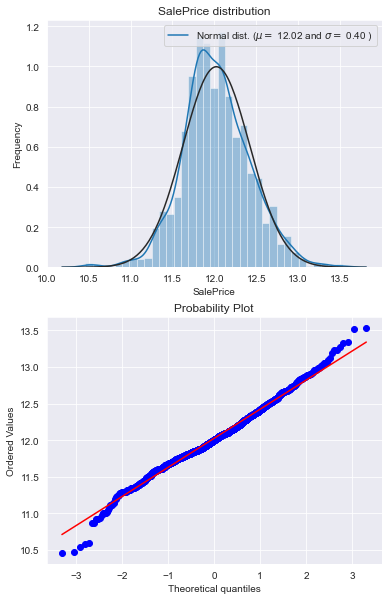

In [410]:
# 使用numpy中函数log1p()将log(1+x)应用于列的所有元素
train["SalePrice"] = np.log1p(train["SalePrice"])

# 查看转换后数据分布
# 分布图
fig, ax = plt.subplots(nrows=2, figsize=(6, 10))
sns.distplot(train['SalePrice'], fit=norm, ax=ax[0])
(mu, sigma) = norm.fit(train['SalePrice'])
ax[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(
    mu, sigma)], loc='best')
ax[0].set_ylabel('Frequency')
ax[0].set_title('SalePrice distribution')

# QQ图
stats.probplot(train['SalePrice'], plot=ax[1])
plt.show()

#### 缺失值处理

In [411]:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data size is : {}".format(all_data.shape)) # print(f"all_data size is : {all_data.shape}")

all_data size is : (2917, 79)


2. 统计各个特征的缺失情况

In [412]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
#pd.set_option('display.max_rows', 500)
all_data_na
#pd.reset_option('display.max_rows')

MSSubClass       0.000
MSZoning         0.137
LotFrontage     16.661
LotArea          0.000
Street           0.000
                 ...  
MiscVal          0.000
MoSold           0.000
YrSold           0.000
SaleType         0.034
SaleCondition    0.000
Length: 79, dtype: float64

In [413]:
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False) 
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


In [414]:
missing_data.shape[0]

34

Text(0.5, 1.0, 'Percent missing data by feature')

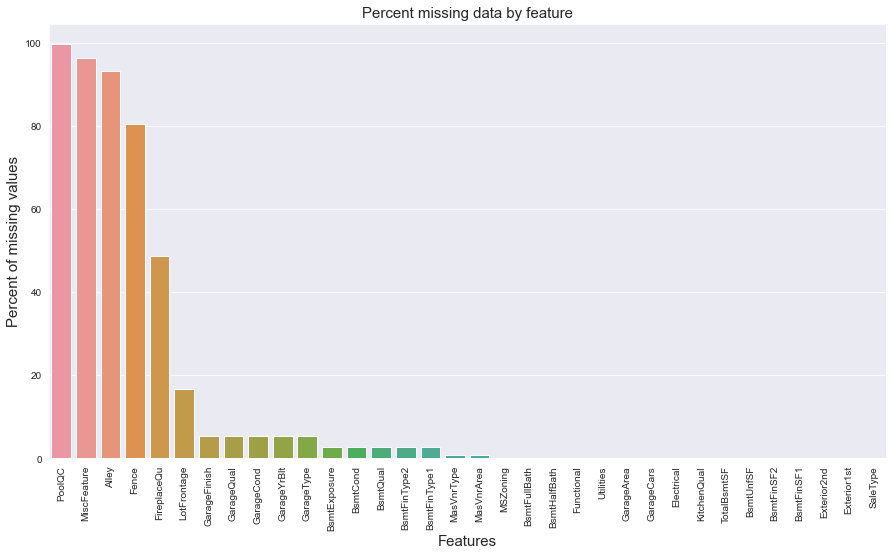

In [415]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

3. 填补缺失值

In [416]:
# 用None或0填补25个含缺失值特征
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

对于缺失较少的离散型特征，可以用众数填补缺失值。 

In [417]:
# 用众数填补6个缺失较少的离散型特征缺失值
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

- **LotFrontage** : ，通过**该社区的 LotFrontage 中位数**来填充缺失值。

In [418]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [419]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [420]:
all_data = all_data.drop(['Utilities'], axis=1)

4. 最后确认缺失值是否已全部处理完毕

In [421]:
all_data.isnull().sum().max()

0

#### 特征相关性  **相关性矩阵热图**



<AxesSubplot:>

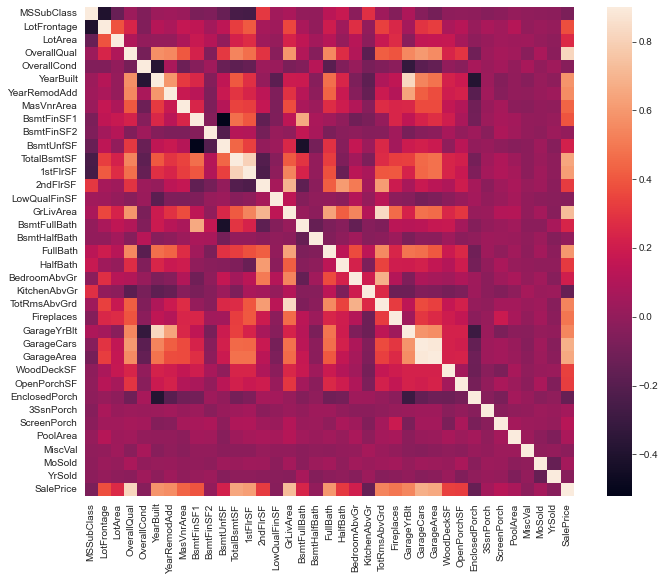

In [422]:
# seaborn中函数heatmap()
corrmat = train.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

#### 进一步挖掘特征

1. 转换部分数值特征为分类特征
- **MSSubClass**   住宅标识
- **YrSold**  开售年份
- **MoSold**  开售月份

In [423]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)  # apply()函数默认对列进行操作
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

2. 转换部分分类特征为数值特征

In [357]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope','LotShape', 
        'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond','YrSold', 'MoSold')

# 处理列，将标签编码应用于分类特征
for c in cols:
    lbl = LabelEncoder()   
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


3. 利用一些重要的特征构造更多的特征

- TotalBsmtSF：地下室总面积
- 1stFlrSF：一层面积
- 2ndFlrSF：二层面积
- OverallQual：整体材料和装饰综合质量
- GrLivArea：地上生活面积
- TotRmsAbvGrd：地上总房间数
- GarageArea：车库面积
- YearBuilt：建造时间

In [358]:
# 构造更多的特征
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] # 房屋总面积

all_data['OverallQual_TotalSF'] = all_data['OverallQual'] * all_data['TotalSF']  # 整体质量与房屋总面积交互项
all_data['OverallQual_GrLivArea'] = all_data['OverallQual'] * all_data['GrLivArea'] # 整体质量与地上总房间数交互项
all_data['OverallQual_TotRmsAbvGrd'] = all_data['OverallQual'] * all_data['TotRmsAbvGrd'] # 整体质量与地上生活面积交互项
all_data['GarageArea_YearBuilt'] = all_data['GarageArea'] * all_data['YearBuilt'] # 车库面积与建造时间交互项

#### 对特征进行Box-Cox变换

1. 对于数值型特征，希望尽量服从正态分布，计算一下各个特征的偏度：

In [359]:
# 筛选出所有数值型特征(63个)
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index  

# 计算特征的偏度
numeric_data = all_data[numeric_feats]
skewed_feats = numeric_data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


2. 对高偏度的特征进行Box-Cox变换

In [360]:
new_skewness = skewness[skewness.abs() > 0.75]
print("有{}个高偏度特征被Box-Cox变换".format(new_skewness.shape[0]))

有63个高偏度特征被Box-Cox变换


我们使用 scipy 中 boxcox1p() 函数计算**\\(1 + x\\) 的 Box-Cox 变换** ，当\\( \lambda = 0 \\) 等效于目标变量的 log1p

选出偏度绝对值大于0.75的数据；找出这些偏度对应的特征；将偏度平滑至0.15


In [361]:
from scipy.special import boxcox1p

skewed_features = new_skewness.index 
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

#### 独热编码（one-hot encoding)

上述主要是在处理数值型特征，接下来我们处理类别特征。

In [365]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 224)


### 建立模型


#### 导入算法包

In [366]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [367]:
y_train = train.SalePrice.values
train = all_data[:train.shape[0]]
test = all_data[train.shape[0]:]

#### 评价函数 ——5折现交叉模型

In [368]:
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return(rmse)

#### 基本模型

-  **LASSO Regression（套索回归）**  


In [369]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

- **Kernel Ridge Regression（核岭回归）** 

In [371]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

- **ElasticNet Regression（弹性网络）** 

In [370]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

- **Gradient Boosting Regression（梯度提升回归GBRT）**


In [372]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5) # 设置hue loss使其对异常值具有鲁棒性

- **XGBoost（极致梯度回归）** 

In [373]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.05,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.8, n_estimators=2200,
                             reg_alpha=0.5, reg_lambda=0.8,
                             subsample=0.5, random_state=7, nthread=-1)

- **LightGBM** 

In [374]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11, verbose=-1)

**基本模型效果评价**

让我们通过评估交叉验证 RMSE 的均值和标准差来看看这些基础模型的表现

In [375]:
models = {'Lasso': lasso, 'ElasticNet': ENet, 'Kernel Ridge': KRR, 
          'Gradient Boosting': GBoost, 'XGBoost': model_xgb, 'LightGBM': model_lgb}
for model_name, model in models.items():
    score = rmsle_cv(model)
    print("{}: {:.4f} ({:.4f})\n".format(model_name, score.mean(), score.std()))

Lasso: 0.1114 (0.0073)

ElasticNet: 0.1115 (0.0074)

Kernel Ridge: 0.1175 (0.0081)

Gradient Boosting: 0.1168 (0.0081)

XGBoost: 0.1172 (0.0060)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[Li

#### 堆叠方法（[Stacking Models][1]）

[1]: https://www.jianshu.com/p/59313f43916f


定义一个新类，表示Stacking方法

In [376]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models  # 第一层模型
        self.meta_model = meta_model    # 第二层模型
        self.n_folds = n_folds

    # 运用克隆的基本模型拟合数据
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # 训练克隆的第一层模型
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # 使用交叉验证预测的结果作为新特征，来训练克隆的第二层模型
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # 在测试数据上做所有基础模型的预测，并使用平均预测作为由元模型完成的最终预测的元特征
    def predict(self, X):
        meta_features = np.column_stack([np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) 
                                         for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

这里我们用ENet、KRR和GBoost作为第一层学习器，用Lasso作为第二层学习器。查看以下Stacking的交叉验证评分：

In [377]:
stacked_averaged_models = StackingAveragedModels(base_models=(ENet, GBoost, KRR), meta_model=lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1083 (0.0074)


#### 建立最终模型

**集成StackedRegressor, XGBoost和 LightGBM**

**我们将XGBoost、LightGBM和StackedRegressor以加权平均的方式融合在一起，建立最终的预测模型**

1. 首先，定义一个评价函数,表示预测值和实际值之间的均方根误差 RMSE

In [378]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

2. 其次，用整个训练集训练模型，预测测试集的房价，并给出模型在训练集上的评分

- **StackedRegressor:**

In [379]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))  
print(rmsle(y_train, stacked_train_pred))

0.07631937112034795


- **XGBoost:**

In [380]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07971210954256541


- **LightGBM:**

In [381]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.07158286128042535


In [384]:
print('集成模型的得分:{}'.format(rmsle(y_train, stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15)))

集成模型的得分:0.07411433251896657


3. 生成最终预测结果

In [385]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

#### 提交结果

In [386]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv', index=False)